# Regressão Linear Múltipla com MQO (Mínimos Quadrados Ordinários)

### Importando Bibliotecas Necessárias

In [2]:
from ucimlrepo import fetch_ucirepo
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

from trabalho_ic_aplicada.models.aux import plot_disperssao_hist_residuo


2025-08-22 15:27:59.050 | INFO     | trabalho_ic_aplicada.config:<module>:11 - PROJ_ROOT path is: /home/apo-note/Documents/Github/Trabalhos_IC_Aplicada


In [3]:
# Modulos personalizados, com modelos de regressão linear e funções auxiliares

import trabalho_ic_aplicada.models.ridge_reg_linear_MQO as reglin
import trabalho_ic_aplicada.models.aux as aux

### Importando o Dataset

In [4]:
# fetch dataset
real_estate_valuation = fetch_ucirepo(id=477)

features = real_estate_valuation.variables.iloc[1:, 0].values
# data (as pandas dataframes)
X = real_estate_valuation.data.features.to_numpy()

# Removendo a primeira coluna (X1 transaction date) que não é um atributo relevante, segundo analise.
# X = X[:, 1:]

y = real_estate_valuation.data.targets.to_numpy().ravel()

### Divisão dos Dados em Conjuntos de Treinamento e Teste

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [6]:
k_fold = aux.validacao_cruzada_kfold(X,y,k=10)


## Treinamento do Modelo de Regressão Linear com Regularização L2 (Ridge


O melhor caso acontece quando uso a normalização Interquartil. Quando as outras normalizações ajudam a não criar valores muito altos para os coeficientes, apesar de não melhorar o desempenho. NO entanto, a normalização Interquatil (robusta) melhora o desempenho em todas as metricas, superando o artigo.



### Validação Cruzada K-Fold

#### Sem Normalização dos Dados

In [7]:
%%time

eqms = []
reqms = []
r_quadrados = []
hit_rates_20 = []
hit_rates_10 = []

for k in range(len(k_fold)):
    X_train_k = X[k_fold[k][0], :]
    y_train_k = y[k_fold[k][0]]

    # Treinamento do modelo de regressão linear com regularização L2
    b_h = reglin.treinar_reglin_l2(X_train_k, y_train_k, lambda_reg=0.01)

    X_test_k = X[k_fold[k][1], :]
    y_test_k = y[k_fold[k][1]]

    # Previsão nos dados de teste
    y_pred_k = reglin.prever(b_h, X_test_k)

    # Avaliação do modelo
    eqm = np.mean((y_test_k - y_pred_k) ** 2)
    reqm = np.sqrt(eqm)
    r_quadrado = 1 - (np.sum((y_test_k - y_pred_k) ** 2) / np.sum((y_test - np.mean(y_test_k)) ** 2))
    hit_rate_20 = aux.error_rit_rate(y_test_k, y_pred_k, 0.20)
    hit_rate_10 = aux.error_rit_rate(y_test_k, y_pred_k, 0.10)

    eqms.append(eqm)
    reqms.append(reqm)
    r_quadrados.append(r_quadrado)
    hit_rates_20.append(hit_rate_20)
    hit_rates_10.append(hit_rate_10)

print(f"Erro Quadrático Médio (EQM): {np.mean(eqms):.4f} ± {np.std(eqms):.4f}")
print(f"Raiz do Erro Quadrático Médio (REQM): {np.mean(reqms):.4f} ± {np.std(reqms):.4f}")
print(f"Coeficiente de Determinação (R²): {np.mean(r_quadrados):.4f} ± {np.std(r_quadrados):.4f}")
print(f"Hit rate 20%: {np.mean(hit_rates_20):.4f} ± {np.std(hit_rates_20):.4f}")
print(f"Hit rate 10%: {np.mean(hit_rates_10):.4f} ± {np.std(hit_rates_10):.4f}\n")

print(f"Intercepto (b[0]): {b_h[0]:.4f}")
for i in range(0, len(b_h)):
    print(f"Atributo: {features[i]} | b[{i}]: {b_h[i]:.4f}")

Erro Quadrático Médio (EQM): 81.5890 ± 36.3494
Raiz do Erro Quadrático Médio (REQM): 8.8397 ± 1.8570
Coeficiente de Determinação (R²): 0.8791 ± 0.0552
Hit rate 20%: 0.6979 ± 0.0781
Hit rate 10%: 0.3914 ± 0.0799

Intercepto (b[0]): -2.9194
Atributo: X1 transaction date | b[0]: -2.9194
Atributo: X2 house age | b[1]: 4.1642
Atributo: X3 distance to the nearest MRT station | b[2]: -0.2409
Atributo: X4 number of convenience stores | b[3]: -0.0056
Atributo: X5 latitude | b[4]: 1.2178
Atributo: X6 longitude | b[5]: 136.0396
Atributo: Y house price of unit area | b[6]: -96.5488
CPU times: user 4.66 ms, sys: 82 μs, total: 4.74 ms
Wall time: 4.47 ms


#### Z-Score

In [8]:

%%time
eqms_z = []
reqms_z = []
r_quadrados_z = []
hit_rates_20_z = []
hit_rates_10_z = []

from sklearn.preprocessing import StandardScaler


for k in range(len(k_fold)):
    X_train_k_z = X[k_fold[k][0], :]
    y_train_k = y[k_fold[k][0]]

    # Normalização dos dados usando Z-Score
    scaler = StandardScaler()
    X_train_k_z = scaler.fit_transform(X_train_k_z)

    # Treinamento do modelo de regressão linear com regularização L2
    b_h_z = reglin.treinar_reglin_l2(X_train_k_z, y_train_k, lambda_reg=0.01)

    X_test_k_z = X[k_fold[k][1], :]
    # Normalização dos dados de teste usando Z-Score
    X_test_k_z = scaler.transform(X_test_k_z)

    y_test_k = y[k_fold[k][1]]

    # Previsão nos dados de teste
    y_pred_k_z = reglin.prever(b_h_z, X_test_k_z)

    # Avaliação do modelo
    eqm = np.mean((y_test_k - y_pred_k_z) ** 2)
    reqm = np.sqrt(eqm)
    r_quadrado = 1 - (np.sum((y_test_k - y_pred_k_z) ** 2) / np.sum((y_test - np.mean(y_test_k)) ** 2))
    hit_rate_20 = aux.error_rit_rate(y_test_k, y_pred_k_z, 0.20)
    hit_rate_10 = aux.error_rit_rate(y_test_k, y_pred_k_z, 0.10)

    eqms_z.append(eqm)
    reqms_z.append(reqm)
    r_quadrados_z.append(r_quadrado)
    hit_rates_20_z.append(hit_rate_20)
    hit_rates_10_z.append(hit_rate_10)

print(f"Erro Quadrático Médio (EQM): {np.mean(eqms_z):.4f} ± {np.std(eqms_z):.4f}")
print(f"Raiz do Erro Quadrático Médio (REQM): {np.mean(reqms_z):.4f} ± {np.std(reqms_z):.4f}")
print(f"Coeficiente de Determinação (R²): {np.mean(r_quadrados_z):.4f} ± {np.std(r_quadrados_z):.4f}")
print(f"Hit rate 20%: {np.mean(hit_rates_20_z):.4f} ± {np.std(hit_rates_20_z):.4f}")
print(f"Hit rate 10%: {np.mean(hit_rates_10_z):.4f} ± {np.std(hit_rates_10_z):.4f}\n")

print(f"Intercepto (b[0]): {b_h_z[0]:.4f}")
for i in range(0, len(b_h_z)):
    print(f"Atributo: {features[i]} | b[{i}]: {b_h_z[i]:.4f}")


Erro Quadrático Médio (EQM): 81.0018 ± 37.0052
Raiz do Erro Quadrático Médio (REQM): 8.8023 ± 1.8766
Coeficiente de Determinação (R²): 0.8800 ± 0.0563
Hit rate 20%: 0.6904 ± 0.0825
Hit rate 10%: 0.3839 ± 0.0765

Intercepto (b[0]): 37.6724
Atributo: X1 transaction date | b[0]: 37.6724
Atributo: X2 house age | b[1]: 1.6830
Atributo: X3 distance to the nearest MRT station | b[2]: -2.7942
Atributo: X4 number of convenience stores | b[3]: -5.6084
Atributo: X5 latitude | b[4]: 3.5196
Atributo: X6 longitude | b[5]: 2.4654
Atributo: Y house price of unit area | b[6]: -0.0811
CPU times: user 12.1 ms, sys: 74 μs, total: 12.1 ms
Wall time: 11.2 ms


#### Min-Max

In [9]:
%%time

eqms_mm = []
reqms_mm = []
r_quadrados_mm = []
hit_rates_20_mm = []
hit_rates_10_mm = []

from sklearn.preprocessing import MinMaxScaler

for k in range(len(k_fold)):
    X_train_k_mm = X[k_fold[k][0], :]
    y_train_k = y[k_fold[k][0]]

    # Normalização dos dados usando Min-Max
    scaler_mm = MinMaxScaler()
    X_train_k_mm = scaler_mm.fit_transform(X_train_k_mm)

    # Treinamento do modelo de regressão linear com regularização L2
    b_h_mm = reglin.treinar_reglin_l2(X_train_k_mm, y_train_k, lambda_reg=0.01)

    X_test_k_mm = X[k_fold[k][1], :]
    # Normalização dos dados de teste usando Min-Max
    X_test_k_mm = scaler_mm.transform(X_test_k_mm)

    y_test_k = y[k_fold[k][1]]

    # Previsão nos dados de teste
    y_pred_k_mm = reglin.prever(b_h_mm, X_test_k_mm)

    # Avaliação do modelo
    eqm = np.mean((y_test_k - y_pred_k_mm) ** 2)
    reqm = np.sqrt(eqm)
    r_quadrado = 1 - (np.sum((y_test_k - y_pred_k_mm) ** 2) / np.sum((y_test - np.mean(y_test_k)) ** 2))
    hit_rate_20 = aux.error_rit_rate(y_test_k, y_pred_k_mm, 0.20)
    hit_rate_10 = aux.error_rit_rate(y_test_k, y_pred_k_mm, 0.10)

    eqms_mm.append(eqm)
    reqms_mm.append(reqm)
    r_quadrados_mm.append(r_quadrado)
    hit_rates_20_mm.append(hit_rate_20)
    hit_rates_10_mm.append(hit_rate_10)

print(f"Erro Quadrático Médio (EQM): {np.mean(eqms_mm):.4f} ± {np.std(eqms_mm):.4f}")
print(f"Raiz do Erro Quadrático Médio (REQM): {np.mean(reqms_mm):.4f} ± {np.std(reqms_mm):.4f}")
print(f"Coeficiente de Determinação (R²): {np.mean(r_quadrados_mm):.4f} ± {np.std(r_quadrados_mm):.4f}")
print(f"Hit rate 20%: {np.mean(hit_rates_20_mm):.4f} ± {np.std(hit_rates_20_mm):.4f}")
print(f"Hit rate 10%: {np.mean(hit_rates_10_mm):.4f} ± {np.std(hit_rates_10_mm):.4f}\n")

print(f"Intercepto (b[0]): {b_h_mm[0]:.4f}")
for i in range(0, len(b_h_mm)):
    print(f"Atributo: {features[i]} | b[{i}]: {b_h_mm[i]:.4f}")


Erro Quadrático Médio (EQM): 80.9965 ± 37.0258
Raiz do Erro Quadrático Médio (REQM): 8.8019 ± 1.8772
Coeficiente de Determinação (R²): 0.8800 ± 0.0563
Hit rate 20%: 0.6904 ± 0.0825
Hit rate 10%: 0.3839 ± 0.0765

Intercepto (b[0]): 32.0353
Atributo: X1 transaction date | b[0]: 32.0353
Atributo: X2 house age | b[1]: 5.4718
Atributo: X3 distance to the nearest MRT station | b[2]: -10.7276
Atributo: X4 number of convenience stores | b[3]: -28.1154
Atributo: X5 latitude | b[4]: 12.0223
Atributo: X6 longitude | b[5]: 16.1407
Atributo: Y house price of unit area | b[6]: -0.3584
CPU times: user 11.7 ms, sys: 1.91 ms, total: 13.6 ms
Wall time: 12.7 ms


#### Interquartil

In [10]:
%%time
eqms_iqr = []
reqms_iqr = []
r_quadrados_iqr = []
hit_rates_20_iqr = []
hit_rates_10_iqr = []

for k in range(len(k_fold)):
    X_train_k_iqr = X[k_fold[k][0], :]
    y_train_k = y[k_fold[k][0]]

    # Normalização dos dados usando Interquartil
    scaler_iqr = QuantileTransformer(n_quantiles=X_train_k_iqr.shape[0],output_distribution='uniform')
    X_train_k_iqr = scaler_iqr.fit_transform(X_train_k_iqr)

    # Treinamento do modelo de regressão linear com regularização L2
    b_h_iqr = reglin.treinar_reglin_l2(X_train_k_iqr, y_train_k, lambda_reg=0.01)

    X_test_k_iqr = X[k_fold[k][1], :]
    # Normalização dos dados de teste usando Interquartil
    X_test_k_iqr = scaler_iqr.transform(X_test_k_iqr)

    y_test_k = y[k_fold[k][1]]

    # Previsão nos dados de teste
    y_pred_k_iqr = reglin.prever(b_h_iqr, X_test_k_iqr)

    # Avaliação do modelo
    eqm = np.mean((y_test_k - y_pred_k_iqr) ** 2)
    reqm = np.sqrt(eqm)
    r_quadrado = 1 - (np.sum((y_test_k - y_pred_k_iqr) ** 2) / np.sum((y_test - np.mean(y_test_k)) ** 2))
    hit_rate_20 = aux.error_rit_rate(y_test_k, y_pred_k_iqr, 0.20)
    hit_rate_10 = aux.error_rit_rate(y_test_k, y_pred_k_iqr, 0.10)

    eqms_iqr.append(eqm)
    reqms_iqr.append(reqm)
    r_quadrados_iqr.append(r_quadrado)
    hit_rates_20_iqr.append(hit_rate_20)
    hit_rates_10_iqr.append(hit_rate_10)

print(f"Erro Quadrático Médio (EQM): {np.mean(eqms_iqr):.4f} ± {np.std(eqms_iqr):.4f}")
print(f"Raiz do Erro Quadrático Médio (REQM): {np.mean(reqms_iqr):.4f} ± {np.std(reqms_iqr):.4f}")
print(f"Coeficiente de Determinação (R²): {np.mean(r_quadrados_iqr):.4f} ± {np.std(r_quadrados_iqr):.4f}")
print(f"Hit rate 20%: {np.mean(hit_rates_20_iqr):.4f} ± {np.std(hit_rates_20_iqr):.4f}")
print(f"Hit rate 10%: {np.mean(hit_rates_10_iqr):.4f} ± {np.std(hit_rates_10_iqr):.4f}\n")

print(f"Intercepto (b[0]): {b_h_iqr[0]:.4f}")
for i in range(0, len(b_h_iqr)):
    print(f"Atributo: {features[i]} | b[{i}]: {b_h_iqr[i]:.4f}")

Erro Quadrático Médio (EQM): 63.1004 ± 34.4017
Raiz do Erro Quadrático Médio (REQM): 7.6838 ± 2.0149
Coeficiente de Determinação (R²): 0.9063 ± 0.0522
Hit rate 20%: 0.7800 ± 0.0615
Hit rate 10%: 0.4697 ± 0.1185

Intercepto (b[0]): 41.9725
Atributo: X1 transaction date | b[0]: 41.9725
Atributo: X2 house age | b[1]: 7.1839
Atributo: X3 distance to the nearest MRT station | b[2]: -8.9113
Atributo: X4 number of convenience stores | b[3]: -25.0528
Atributo: X5 latitude | b[4]: 3.8254
Atributo: X6 longitude | b[5]: 12.6641
Atributo: Y house price of unit area | b[6]: 1.7884
CPU times: user 34 ms, sys: 81 μs, total: 34 ms
Wall time: 32.7 ms


# --- Seção 4: Avaliação e Visualização ---

Avg. house price: 37.9745 ± 11.1647
RSME/Avg. house price: 0.1441 ± 0.1541
Erro Quadrático Médio (EQM): 63.1004 ± 34.4017
Raiz do Erro Quadrático Médio (REQM): 7.6838 ± 2.0149
Hit rate 20%: 0.7800 ± 0.0615
Hit rate 10%: 0.4697 ± 0.1185


--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.8506, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.8524, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


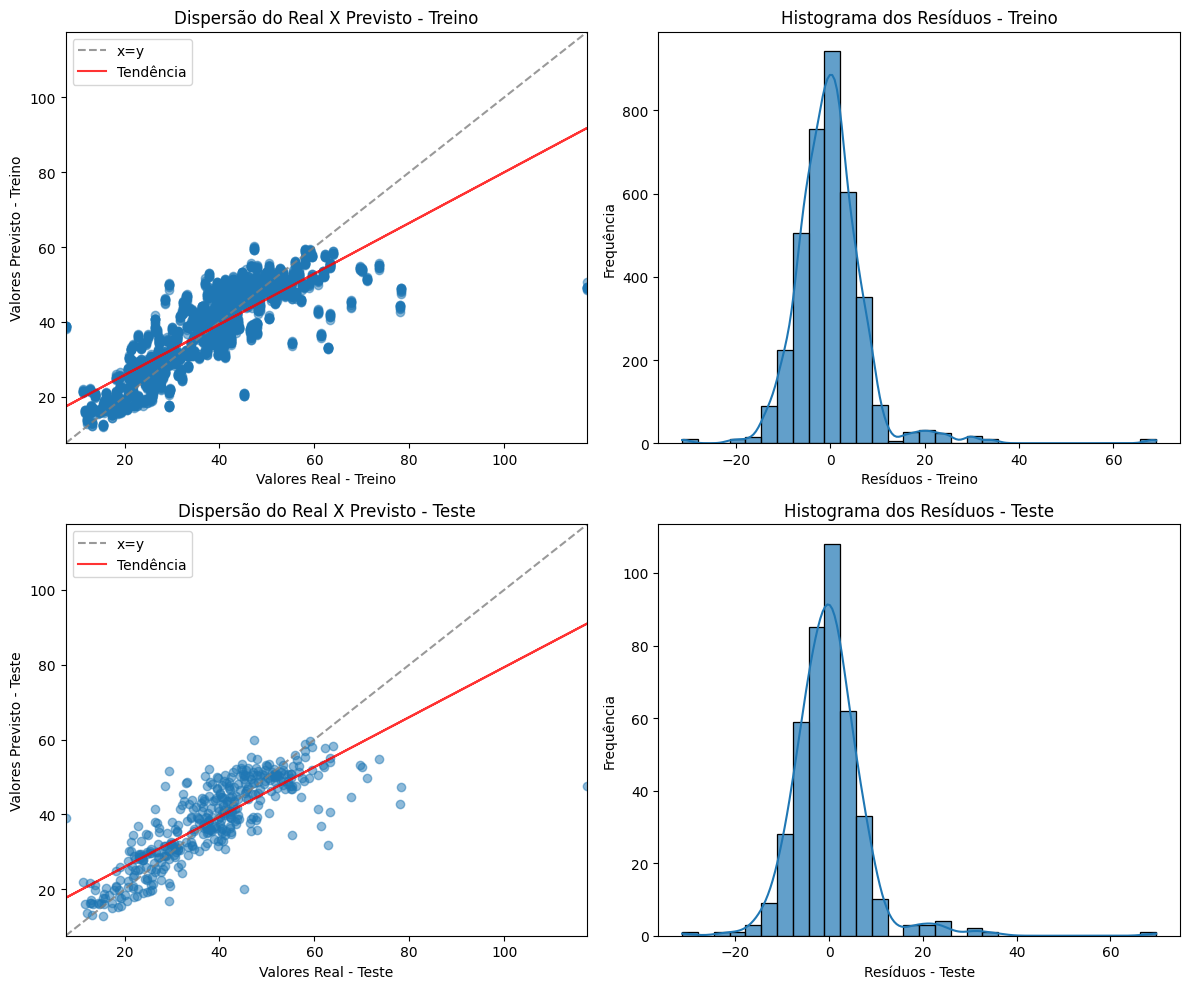

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.8230 ± 0.0083
Correlação Média (Teste): 0.8242 ± 0.0887
Coeficiente de Determinação (R²): 0.6611 ± 0.1354


In [11]:
# Listas para métricas
eqms_iqr = []
reqms_iqr = []
r_quadrados_iqr = []
hit_rates_20_iqr = []
hit_rates_10_iqr = []

# Listas para resíduos e correlações
correlacoes_treino = []
correlacoes_teste = []

# Listas para análise final
y_trains = []
y_train_preds = []
y_tests = []
y_test_preds = []

# Loop de validação cruzada
for k in range(len(k_fold)):
    # Dados de treino
    X_train_k = X[k_fold[k][0], :]
    y_train_k = y[k_fold[k][0]]

    # Normalização
    scaler = QuantileTransformer(n_quantiles=X_train_k.shape[0], output_distribution='uniform')
    X_train_k = scaler.fit_transform(X_train_k)

    # Treinamento
    b = reglin.treinar_reglin_l2(X_train_k, y_train_k, lambda_reg=0.01)

    # Previsão treino
    y_pred_train = reglin.prever(b, X_train_k)
    corr_treino = np.corrcoef(y_train_k.flatten(), y_pred_train.flatten())[0, 1]
    correlacoes_treino.append(corr_treino)

    # Dados de teste
    X_test_k = X[k_fold[k][1], :]
    y_test_k = y[k_fold[k][1]]
    X_test_k = scaler.transform(X_test_k)

    # Previsão teste
    y_pred_test = reglin.prever(b, X_test_k)

    corr_teste = np.corrcoef(y_test_k.flatten(), y_pred_test.flatten())[0, 1]
    correlacoes_teste.append(corr_teste)

    # Armazenar para análises finais
    y_trains.extend(y_train_k)
    y_train_preds.extend(y_pred_train)
    y_tests.extend(y_test_k)
    y_test_preds.extend(y_pred_test)

    # Cálculo de métricas e resíduos
    eqm, reqm, r2, hit20, hit10, _ = aux.calcular_metricas(y_test_k, y_pred_test, aux)
    eqms_iqr.append(eqm)
    reqms_iqr.append(reqm)
    r_quadrados_iqr.append(r2)
    hit_rates_20_iqr.append(hit20)
    hit_rates_10_iqr.append(hit10)



# Converter para array
y_trains = np.array(y_trains)
y_train_preds = np.array(y_train_preds)
y_tests = np.array(y_tests)
y_test_preds = np.array(y_test_preds)


aux.calcular_metricas_normalizadas(y_test_preds, y_tests)
# Imprimir métricas
aux.imprimir_metricas(eqms_iqr, reqms_iqr, r_quadrados_iqr, hit_rates_20_iqr, hit_rates_10_iqr)

# Análise dos resíduos + gráfico + shapiro
aux.analisar_residuos(
    y_trains, y_train_preds,
    y_tests, y_test_preds,
    aux,
    titulo='Regressão Linear Múltipla com MQO (Mínimos Quadrados Ordinários)'
)

# Correlações
aux.imprimir_correlacoes(correlacoes_treino, correlacoes_teste, r_quadrados_iqr)


=== MELHOR COMBINAÇÃO (CV no TREINO) ===
{'normalizacao': 'iqr', 'lambda': 0.5, 'r2_val_mean': 0.662380846947382, 'rmse_val_mean': 8.026831264671936, 'hit10_val_mean': 0.3941945773524721, 'hit20_val_mean': 0.7694417862838916}

=== DESEMPENHO NO TESTE (HOLD-OUT) ===
R² = 0.6893 | RMSE = 7.0594 | EQM = 49.8349 | Hit@10 = 0.5255 | Hit@20 = 0.7956
Avg. house price: 36.5454 ± 11.0045
RSME/Avg. house price: 0.1431 ± 0.1698

=== TOP-5 combinações na CV (médias de validação) ===
    iqr | λ=   0.5 | R²=0.6624 | RMSE=8.0268 | Hit@10=0.3942 | Hit@20=0.7694
    iqr | λ=   0.1 | R²=0.6614 | RMSE=8.0400 | Hit@10=0.4124 | Hit@20=0.7694
    iqr | λ=  0.05 | R²=0.6610 | RMSE=8.0451 | Hit@10=0.4087 | Hit@20=0.7696
    iqr | λ=  0.01 | R²=0.6606 | RMSE=8.0498 | Hit@10=0.4089 | Hit@20=0.7696
    iqr | λ= 0.001 | R²=0.6605 | RMSE=8.0510 | Hit@10=0.4089 | Hit@20=0.7659

=== Coeficientes do modelo (melhor combinação) ===
Intercepto (b[0]): 40.421283
Atributo: X1 transaction date | b[1] = 6.008242
Atributo: 

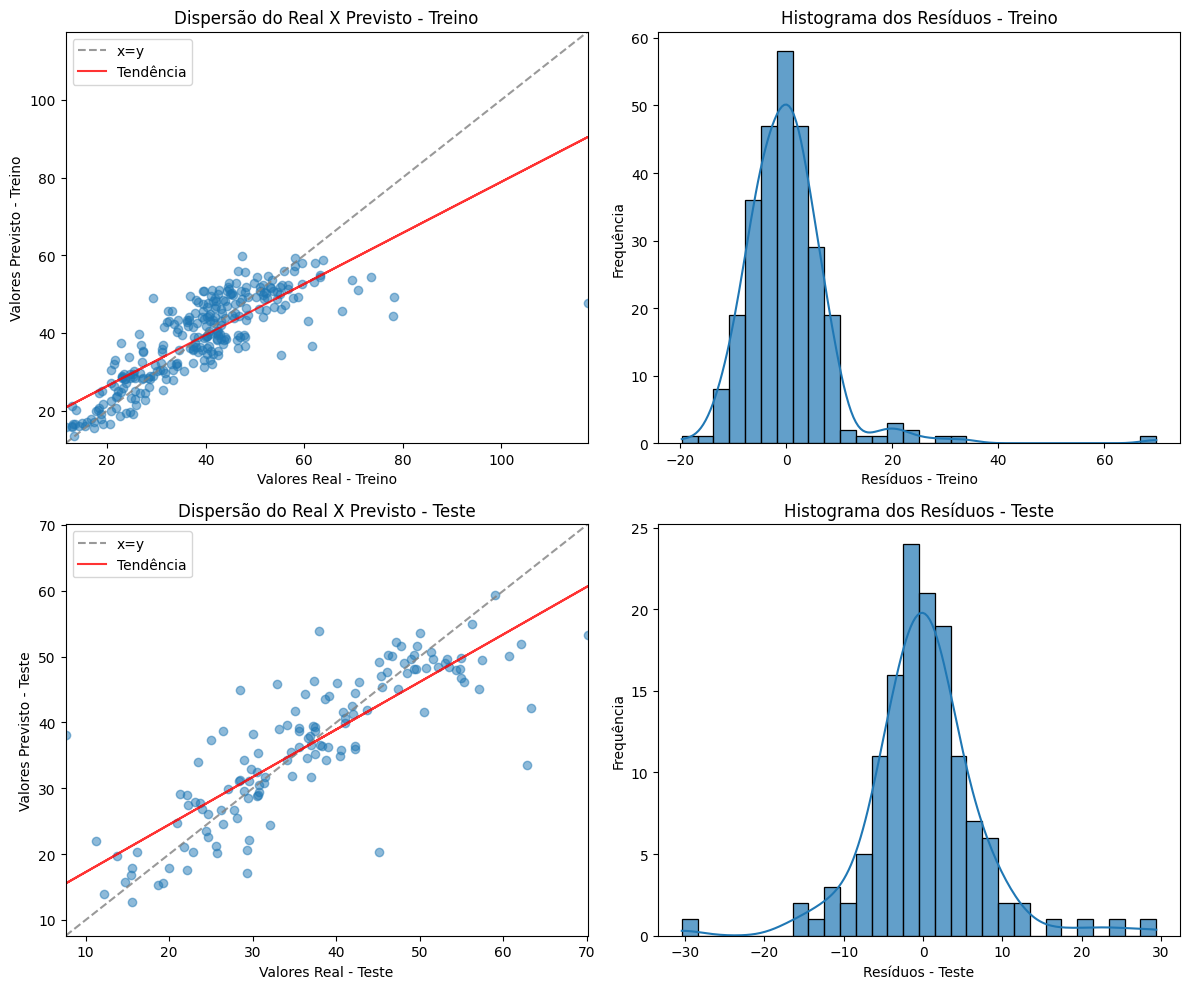

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.8163 ± 0.0000
Correlação Média (Teste): 0.8312 ± 0.0000
Coeficiente de Determinação (R²): 0.6893 ± 0.0000


In [12]:
# Seleção de normalização + hiperparâmetro (λ) via CV no TREINO e avaliação no TESTE (hold-out)

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer

# ---------------------------------------------------------------------
# (1) Split treino/teste reprodutível
# ---------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# ---------------------------------------------------------------------
# (2) K-fold = 5 somente na base de TREINO
#     (usa sua função para obter índices de treino/validação INTRA-treino)
# ---------------------------------------------------------------------
k_fold_train = aux.validacao_cruzada_kfold(X_train, y_train, k=5)

# ---------------------------------------------------------------------
# (3) Espaço de busca: normalizações + λ do Ridge
#     (λ=0 equivale a MQO; valores >0 impõem L2)
# ---------------------------------------------------------------------
lambda_grid = [0.0, 1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 0.5, 1.0, 2.0, 5.0, 10.0]
norm_options = ["none", "zscore", "minmax", "iqr"]


def make_scaler(name: str, n_samples: int):
    if name == "none":
        # No-op scaler com mesma interface
        class _NoOp:
            def fit(self, X): return self

            def transform(self, X): return X

            def fit_transform(self, X): return X

        return _NoOp()
    elif name == "zscore":
        return StandardScaler()
    elif name == "minmax":
        return MinMaxScaler()
    elif name == "iqr":
        # "Interquartil" como você vinha usando (Quantile → distribuição uniforme)
        return QuantileTransformer(
            n_quantiles=min(n_samples, 1000),
            output_distribution="uniform",
            random_state=42
        )
    else:
        raise ValueError(f"Normalização desconhecida: {name}")


# ---------------------------------------------------------------------
# (4) Avaliação por CV no treino para cada (normalização, λ)
#     Métrica principal: R² médio de validação.
#     Desempates: menor RMSE e maior Hit@10%.
# ---------------------------------------------------------------------
cv_results = []  # guardará dicionários com médias por combinação

for norm_name in norm_options:
    for lam in lambda_grid:
        r2_list, rmse_list, hit10_list, hit20_list = [], [], [], []

        for k in range(len(k_fold_train)):
            tr_idx, va_idx = k_fold_train[k]

            X_tr_k = X_train[tr_idx, :]
            y_tr_k = y_train[tr_idx]
            X_va_k = X_train[va_idx, :]
            y_va_k = y_train[va_idx]

            scaler = make_scaler(norm_name, X_tr_k.shape[0])
            X_tr_k_s = scaler.fit_transform(X_tr_k)
            b = reglin.treinar_reglin_l2(X_tr_k_s, y_tr_k, lambda_reg=lam)

            X_va_k_s = scaler.transform(X_va_k)
            y_va_pred = reglin.prever(b, X_va_k_s)

            # usa sua função de métricas (eqm, reqm, r2, hit20, hit10, _)
            eqm, reqm, r2, hit20, hit10, _ = aux.calcular_metricas(y_va_k, y_va_pred, aux)
            r2_list.append(r2)
            rmse_list.append(reqm)
            hit10_list.append(hit10)
            hit20_list.append(hit20)

        cv_results.append({
            "normalizacao": norm_name,
            "lambda": lam,
            "r2_val_mean": float(np.mean(r2_list)),
            "rmse_val_mean": float(np.mean(rmse_list)),
            "hit10_val_mean": float(np.mean(hit10_list)),
            "hit20_val_mean": float(np.mean(hit20_list))
        })

# ordenar por melhor R² (desc), depois RMSE (asc), depois Hit@10 (desc)
cv_results_sorted = sorted(
    cv_results,
    key=lambda d: (-d["r2_val_mean"], d["rmse_val_mean"], -d["hit10_val_mean"])
)

best = cv_results_sorted[0]
print("=== MELHOR COMBINAÇÃO (CV no TREINO) ===")
print(best)

# ---------------------------------------------------------------------
# (5) Reajuste no TREINO COMPLETO com a melhor combinação e avaliação no TESTE
# ---------------------------------------------------------------------
scaler_best = make_scaler(best["normalizacao"], X_train.shape[0])
X_train_s = scaler_best.fit_transform(X_train)
b_best = reglin.treinar_reglin_l2(X_train_s, y_train, lambda_reg=best["lambda"])

X_test_s = scaler_best.transform(X_test)
y_test_pred = reglin.prever(b_best, X_test_s)

# Métricas no hold-out (teste)
eqm_test, rmse_test, r2_test, hit20_test, hit10_test, _ = aux.calcular_metricas(y_test, y_test_pred, aux)

print("\n=== DESEMPENHO NO TESTE (HOLD-OUT) ===")
print(f"R² = {r2_test:.4f} | RMSE = {rmse_test:.4f} | EQM = {eqm_test:.4f} | "
      f"Hit@10 = {hit10_test:.4f} | Hit@20 = {hit20_test:.4f}")

# ---------------------------------------------------------------------
# (6) Resíduos apenas no HOLD-OUT (sem k-fold), preservando sua análise
# ---------------------------------------------------------------------
# Predições no treino (para a seção de resíduos)
y_train_pred = reglin.prever(b_best, X_train_s)

# Opcional: métricas normalizadas agregadas (se você usa essa rotina)
aux.calcular_metricas_normalizadas(y_test_pred, y_test)

# Impressão resumida das top-5 combinações de CV
print("\n=== TOP-5 combinações na CV (médias de validação) ===")
for row in cv_results_sorted[:5]:
    print(f"{row['normalizacao']:>7} | λ={row['lambda']:>6} | "
          f"R²={row['r2_val_mean']:.4f} | RMSE={row['rmse_val_mean']:.4f} | "
          f"Hit@10={row['hit10_val_mean']:.4f} | Hit@20={row['hit20_val_mean']:.4f}")

# ---------------------------------------------------------------------
# (7) Impressão de coeficientes do modelo vencedor (se desejar)
# ---------------------------------------------------------------------
# Tenta mapear nomes de atributos corretamente (evita conflito com 'features' antigo)
try:
    feature_names = real_estate_valuation.data.features.columns.to_numpy()
except Exception:
    feature_names = [f"x{j + 1}" for j in range(X.shape[1])]

print("\n=== Coeficientes do modelo (melhor combinação) ===")
print(f"Intercepto (b[0]): {b_best[0]:.6f}")
n_coefs = min(len(feature_names), len(b_best) - 1)
for j in range(n_coefs):
    print(f"Atributo: {feature_names[j]} | b[{j + 1}] = {b_best[j + 1]:.6f}")

# ---------------------------------------------------------------------
# (8) Análise de resíduos (apenas hold-out)
# ---------------------------------------------------------------------
aux.analisar_residuos(
    y_train, y_train_pred,
    y_test, y_test_pred,
    aux,
    titulo='Regressão Linear (Ridge/MQO) — hold-out'
)


from sklearn.metrics import r2_score
corr_tr = np.corrcoef(y_train, y_train_pred)[0, 1]
corr_te = np.corrcoef(y_test, y_test_pred)[0, 1]
r2_t = r2_score(y_test, y_test_pred)

aux.imprimir_correlacoes([corr_tr], [corr_te], [r2_t])


### O Que Significa o Teste de Shapiro-Wilk?

O teste de Shapiro-Wilk é um teste de hipótese formal para verificar a normalidade de uma amostra de dados. A lógica por trás dele é a seguinte:

1.  **Hipótese Nula ($H_0$):** O teste parte da premissa de que a sua amostra de dados (no seu caso, os resíduos do modelo) foi extraída de uma população com distribuição normal.
2.  **p-valor:** O p-valor representa a probabilidade de se obter uma amostra tão ou mais distante da normalidade quanto a sua, **assumindo que a hipótese nula ($H_0$) seja verdadeira**.
3.  **Regra de Decisão:** Compara-se o p-valor com um nível de significância, $\alpha$ (geralmente 0.05).
    * Se `p-valor > α`, não há evidência estatística para rejeitar a hipótese nula. Concluímos que os dados podem ser considerados normais.
    * Se `p-valor < α`, a probabilidade de obter tal amostra de uma população normal é muito baixa. Portanto, **rejeitamos a hipótese nula**.

### Aplicando ao Seu Resultado

No seu caso, tanto para os resíduos de treino quanto para os de teste, o resultado foi: `p-valor=0.0000`.

* **Conclusão Estatística:** Como $0.0000 < 0.05$, você tem uma forte evidência estatística para **rejeitar a hipótese nula**. Isso significa que a distribuição dos erros do seu modelo de regressão linear **não é Gaussiana**.

### Implicações para o seu Projeto (O "E daí?")

Este resultado é mais do que um detalhe estatístico; é um diagnóstico sobre a adequação do seu modelo. [cite_start]O modelo de regressão linear por Mínimos Quadrados Ordinários (MQO) baseia-se em certas premissas para que suas inferências sejam totalmente válidas, e uma delas é a normalidade dos erros ($\epsilon_i \sim N(0, \sigma^2_\epsilon)$)[cite: 2780, 6710]. A violação dessa premissa, indicada pelo seu teste, sugere alguns cenários:

1.  **Não-Linearidade Não Capturada:** Esta é a implicação mais provável. [cite_start]O modelo de regressão linear, por definição, ajusta um hiperplano aos dados[cite: 6685]. Se a relação verdadeira entre as características (idade da casa, distância do metrô, etc.) e o preço do imóvel for intrinsecamente não-linear, o modelo linear será incapaz de capturá-la. Os resíduos (o que "sobra" depois do ajuste do modelo) conterão essa estrutura não-linear, e sua distribuição não será normal.

2.  **Presença de Outliers:** Alguns imóveis com características ou preços muito atípicos (outliers) podem estar gerando erros de previsão muito grandes. Esses erros extremos "esticam" as caudas da distribuição de resíduos, fazendo com que ela falhe no teste de normalidade.

3.  **Heterocedasticidade:** A variância dos erros pode não ser constante em toda a faixa de previsões (uma outra premissa do MQO). Por exemplo, o modelo pode ter erros muito maiores para imóveis caros do que para imóveis baratos.

### Próximos Passos e Argumentos para seu Trabalho

Este resultado é, na verdade, um excelente ponto de partida para justificar o restante do seu trabalho.

* **Justificativa para Modelos Complexos:** Você agora tem uma prova estatística de que o modelo linear simples não é suficiente para descrever completamente a complexidade dos dados. [cite_start]Este é um argumento poderoso para justificar a necessidade de investigar modelos mais flexíveis, como o **Perceptron de Múltiplas Camadas (MLP)**, que é o objetivo principal do seu trabalho[cite: 4244]. [cite_start]A capacidade das MLPs de aproximar funções não-lineares arbitrárias [cite: 6595-6596, 5138] é exatamente o que se precisa para lidar com a situação que seus resíduos estão indicando.

* **Análise Visual:** Volte ao histograma que você gerou. A não-normalidade se manifesta como uma forte assimetria (*skewness*)? Ou talvez como caudas pesadas (*heavy tails*), indicando a presença de outliers? Descrever essa forma visualmente enriquecerá sua análise.

* **Transformação da Variável-Alvo:** Em problemas de regressão com valores monetários (como preços de imóveis), é muito comum que a distribuição seja assimétrica. Uma estratégia clássica para lidar com isso é aplicar uma **transformação logarítmica** na variável de saída (`y`). Tente treinar seu modelo para prever `log(y)` em vez de `y` e refaça a análise dos resíduos. É muito provável que eles se tornem mais próximos de uma distribuição normal.


Excelentes perguntas, que demonstram uma análise crítica dos seus resultados e da metodologia. Vamos abordar cada um dos seus pontos de forma estruturada.

Primeiramente, sua correção é fundamental: o gráfico mostra **Valores Reais (Eixo X) vs. Valores Previstos (Eixo Y)**. Esta é a visualização correta para avaliar o desempenho de um modelo de regressão.

### 1. Interpretação do Gráfico de Dispersão (Real vs. Previsto)

Esta visualização é uma das ferramentas mais poderosas para diagnosticar a performance de um modelo de regressão.

#### Comportamento de um Modelo com Bom Ajuste (*Good Fit*)

* **A Reta Ideal:** Em um cenário perfeito, todos os pontos do gráfico estariam sobre a linha de identidade, ou seja, a reta $y=x$ (uma diagonal de 45 graus que parte da origem). Isso significaria que, para cada amostra, o `Valor Previsto` é exatamente igual ao `Valor Real`.
* **Na Prática:** Um bom modelo apresentará os pontos **fortemente agrupados e distribuídos de forma simétrica em torno dessa reta diagonal de 45 graus**. A nuvem de pontos deve ser "fina" e alongada, indicando que os erros de previsão são pequenos e não sistemáticos.

#### Comportamento de um Modelo com Ajuste Ruim (*Poor Fit*)

* **Dispersão Elevada:** Os pontos ainda podem seguir a tendência diagonal, mas estão muito espalhados (a nuvem de pontos é "gorda"). Isso indica que, embora o modelo capture a tendência geral, seus erros individuais são grandes.
* **Padrão Não Linear:** Se os pontos formam uma curva (por exemplo, um "S" ou uma parábola), isso é um sinal claro de que o modelo linear não é adequado para os dados. O modelo está sistematicamente errando de forma previsível, pois a relação real entre as variáveis é não linear.
* **Nuvem sem Padrão ou Horizontal:** Se a nuvem de pontos é aleatória ou forma uma linha horizontal, o modelo falhou completamente em aprender a relação entre as características e a variável-alvo.

**Analisando o seu gráfico:** Seu modelo parece ter um ajuste razoável. Os pontos claramente seguem uma tendência linear positiva, alinhada com a diagonal ideal. No entanto, há uma dispersão considerável, o que indica a presença de erros de previsão. Este grau de dispersão é exatamente o que as métricas quantitativas irão medir.

### 2. Quantificando o Ajuste e a Relação com RMSE/MSE

Sua intuição está absolutamente correta. A análise visual é o primeiro passo, mas a quantificação é essencial.

* **Relação com RMSE/MSE:** O **Erro Quadrático Médio (MSE)** e sua raiz, o **RMSE**, quantificam diretamente a dispersão que você vê no gráfico. O resíduo ($e_i = y_i - \hat{y}_i$) é a distância vertical de cada ponto até a linha de identidade ($y=x$). O RMSE é, em essência, uma medida da "distância média" dos pontos em relação à linha de ajuste ideal.
    * **Um RMSE/MSE baixo** significa que a nuvem de pontos está **muito próxima e agrupada** em torno da reta diagonal.
    * **Um RMSE/MSE alto** corresponde a uma **nuvem de pontos muito dispersa**.

* **Outras Formas de Quantificar:** Além do RMSE, você deve usar outras duas métricas cruciais para quantificar o que vê neste gráfico:
    1.  **Coeficiente de Correlação de Pearson (r):** Calcule a correlação entre o vetor de valores reais e o vetor de valores previstos. Um modelo perfeito teria uma correlação de +1.0. Um valor alto (e.g., > 0.9) quantifica a forte *tendência linear* que você observa visualmente.
    2.  [cite_start]**Coeficiente de Determinação ($R^2$):** Conforme discutido no documento `regressao_atualizado.pdf`[cite: 8279], o $R^2$ mede a proporção da variância na variável real que é explicada pelo seu modelo. Ele responde à pergunta: "Quão bem meu modelo explica a variabilidade dos dados?". Um $R^2$ de 0.85, por exemplo, significa que seu modelo explica 85% da variabilidade no preço dos imóveis.

### 3. Plotar Resultados do K-Fold: Agregado vs. Uma Rodada

Sua abordagem de agregar os resultados de todos os *folds* e plotá-los em um único gráfico é não apenas correta, mas **altamente recomendada**.

* **Por que agregar é o ideal?** Cada *fold* da validação cruzada produz um modelo ligeiramente diferente, treinado com uma porção ligeiramente diferente dos dados. Um gráfico de um único *fold* representaria o desempenho de apenas uma dessas instâncias do modelo e estaria sujeito ao viés daquela partição específica. Ao agregar as previsões de **todos os *folds***, o seu gráfico de dispersão representa o **desempenho médio e geral** do seu processo de modelagem, não apenas de uma única execução. Ele é uma visualização muito mais honesta e robusta da capacidade de generalização do seu método.

Plotar o resultado de apenas um *fold* seria análogo a realizar uma única divisão treino/teste e basear todas as suas conclusões visuais nela, o que já estabelecemos ser uma prática de baixa robustez estatística. Continue com sua abordagem atual.

Excelente. Você compilou um conjunto completo e muito informativo de resultados para o seu modelo de Regressão Linear por Mínimos Quadrados (MQ). A análise conjunta dessas métricas e gráficos nos permite fazer um diagnóstico preciso do desempenho do modelo.

Vamos interpretar esses resultados de forma estruturada.

### Síntese Geral do Desempenho do Modelo MQ

Seu modelo de regressão linear apresenta um **desempenho moderado, servindo como um bom *baseline*, mas com limitações claras**. Ele foi capaz de capturar a tendência linear principal dos dados, mas falha em modelar relações mais complexas, o que é evidenciado pela violação da premissa de normalidade dos resíduos e por um poder preditivo que deixa espaço para melhorias.

---

### Análise de Performance Preditiva (As Métricas)

* **R² (0.6715 ± 0.1114):** Seu modelo explica, em média, **67.15% da variabilidade** no preço dos imóveis. Este é um resultado razoável para um modelo linear simples, mas indica que aproximadamente 33% da variação nos preços se deve a fatores que o modelo não conseguiu capturar. O desvio padrão de 0.11 sugere que a performance varia consideravelmente dependendo da partição dos dados de treino/teste, o que reforça a importância da validação cruzada.

* **Correlação Média (Teste): 0.8246 ± 0.0721:** Este é um ponto forte. Há uma **forte correlação positiva (r ≈ 0.82)** entre os valores previstos e os valores reais. Isso confirma o que vemos no gráfico de dispersão: o modelo está "olhando na direção certa", e suas previsões sobem e descem de forma consistente com os preços reais.

* **REQM (7.5968 ± 2.1827):** A Raiz do Erro Quadrático Médio indica que o erro de previsão típico do seu modelo é de aproximadamente **7.6 unidades de preço por metro quadrado**. Sem conhecer a faixa de preço exata, este número serve como uma linha de base concreta do erro médio. Seu objetivo com modelos mais complexos será reduzir este valor.

* **Hit Rate 10% (0.4682):** Esta é uma métrica bastante prática e reveladora. Ela nos diz que as previsões do seu modelo estão dentro de uma margem de erro de 10% do valor real em **menos da metade das vezes (≈47%)**. Para uma aplicação de avaliação imobiliária, isso seria considerado um desempenho baixo, destacando a necessidade de um modelo mais preciso.

### Análise Diagnóstica (Os Gráficos e Testes)

Aqui está a chave para entender *por que* o desempenho é moderado.

* **Gráfico de Dispersão (Real vs. Previsto):**
    * **O que está bom:** A nuvem de pontos segue claramente a diagonal de 45 graus, o que é consistente com a alta correlação (r ≈ 0.82) que você calculou. O modelo aprendeu a tendência geral.
    * **O que pode melhorar:** A nuvem de pontos é consideravelmente dispersa. Isso mostra visualmente os erros que o REQM quantifica. Mais importante ainda, a dispersão parece aumentar para valores mais altos (a nuvem fica mais "gorda" à direita). Este é um sinal clássico de **heterocedasticidade**, ou seja, a variância do erro não é constante, violando outra premissa do modelo MQ. O modelo tem mais dificuldade (erra mais) para prever os preços de imóveis mais caros.

* **Histograma e Teste de Shapiro-Wilk (p-valor = 0.0000):**
    * **Conclusão Inequívoca:** Como discutimos, um p-valor tão baixo leva à **rejeição da hipótese de normalidade dos resíduos**. Esta é a evidência estatística mais forte de que o modelo linear é inadequado.
    * **Diagnóstico:** A não normalidade dos resíduos é um sintoma de que há padrões nos dados que o modelo linear não conseguiu capturar. Observando o histograma, vemos uma distribuição que, embora centrada perto de zero, possui uma leve assimetria e não se encaixa perfeitamente na curva de densidade normal.

### Conclusão e Recomendações (Próximos Passos)

O modelo de Regressão Linear por Mínimos Quadrados (MQ) cumpriu seu papel: forneceu um **baseline de desempenho** e, através da análise de seus resíduos, nos deu um diagnóstico claro de que **a relação entre as características e o preço do imóvel é não-linear**.

Sua hipótese de trabalho agora deve ser: **modelos não-lineares, como as Redes Neurais (PL, MLP), serão capazes de capturar a estrutura dos dados que o modelo linear ignorou, resultando em resíduos mais próximos da normalidade e métricas de performance superiores.**

**Ações Recomendadas:**

1.  **Implemente os Modelos Neurais:** Prossiga com a implementação do Perceptron Logístico (PL) e da Rede MLP, conforme solicitado no `TC1_PPGETI_2025_1.pdf`.
2.  **Compare as Métricas Chave:** Seu principal objetivo será demonstrar que a MLP pode superar o baseline do MQ, buscando:
    * Um **R² e uma Correlação maiores**.
    * Um **REQM menor**.
    * Um **Hit Rate maior**.
3.  **Reavalie os Resíduos da MLP:** Este é o passo crítico. Após treinar sua melhor MLP, **repita a análise diagnóstrica**:
    * Gere o histograma dos resíduos da MLP.
    * Execute o teste de Shapiro-Wilk sobre eles.
    * **Sua meta é verificar se o p-valor aumenta (idealmente, tornando-se > 0.05), o que indicaria que a MLP capturou com sucesso as não-linearidades, "limpando" os resíduos e fazendo com que eles se aproximassem de uma distribuição normal.**